<a href="https://colab.research.google.com/github/jenslaufer/Data2Decision/blob/master/notebooks/Case_Number_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data2Decision
* Analyze historic and current data
* Compare effects of counter measures against the spread of the SARS-COV-2 in different countries/ regions
* Simulate forecasts 
* Make informed decisions based on data and models.

## Data
Fetch current and past case numbers from John Hopkins University
### Download

In [0]:
#Setting up libaries (pandas, matplotlib, seaborn, numpy and scipy)
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf

#Importing most recent data from JHU
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
data_confirmed = pd.read_csv(url_confirmed)
data_dead = pd.read_csv(url_deaths)

### Polish and structure data
Two data sets
1.   data confirmed infected cases - **dcc**
2.   data dead cases - **ddc**

In [0]:
#Cleaning the data from JHU
# data confirmed cases
dcc = data_confirmed.rename(columns = {"Province/State": "state", "Country/Region": "country"}) #renaming some columns
dcc = dcc.groupby("country").sum() #summing up values of countries that have their values distributed over states e.g. US, France
dcc = dcc.iloc[:,2:].T.rename(columns = {"Korea, South": "South Korea"}) #transversing the dataframe and rename one column
dcc['day'] = range(0,len(dcc)) #create a column for the day count
dcc['dates'] = dcc.index       #copy the index(dates) to a new column
dcc['datetime'] = pd.to_datetime(dcc['dates'])
dcc = dcc.set_index('datetime')     #make the day count the new index

# data dead cases
ddc = data_dead.rename(columns = {"Province/State": "state", "Country/Region": "country"})
ddc = ddc.groupby("country").sum()
ddc = ddc.iloc[:,2:].T.rename(columns = {"Korea, South": "South Korea"})
ddc['day'] = range(0,len(ddc))
ddc['dates'] = ddc.index
ddc['datetime'] = pd.to_datetime(ddc['dates'])
ddc = ddc.set_index('datetime')     

# day when exponential growth starts for confirmed cases / death cases
expini_data =[['Germany',33,'2/24/20',47,'3/9/20'],
         ['Spain',33,'2/24/20',41,'3/3/20'],
         ['France',33,'2/24/20',34,'2/24/20'],
         ['Italy',29,'2/20/20',30,'2/21/20'],
         ['South Korea',24,'2/15/20',28,'2/19/20'],
         ['US',32,'2/23/20',38,'2/29/20']]
expini = pd.DataFrame(expini_data,columns =['country','confirmed_day','confirmed_date','death_day','death_date']).set_index('country')
expini['confirmed_date'] = pd.to_datetime(expini['confirmed_date'])
expini['death_date'] = pd.to_datetime(expini['death_date'])

### confirmed cases for selected countries

In [0]:
#Output confirmed cases DataFrame
dcc.loc[:,['Germany','Italy','Spain','France','South Korea','US']].tail()

country,Germany,Italy,Spain,France,South Korea,US
datetime,,,,,,
2020-03-17,9257,31506,11748,7699,8320,6421
2020-03-18,12327,35713,13910,9105,8413,7783
2020-03-19,15320,41035,17963,10947,8565,13677
2020-03-20,19848,47021,20410,12726,8652,19100
2020-03-21,22213,53578,25374,14431,8799,25489


### start of exponential growth
List of dates when the exponential growth of cases starts for different countries

In [0]:
expini

,confirmed_day,confirmed_date,death_day,death_date
country,,,,
Germany,33,2020-02-24,47,2020-03-09
Spain,33,2020-02-24,41,2020-03-03
France,33,2020-02-24,34,2020-02-24
Italy,29,2020-02-20,30,2020-02-21
South Korea,24,2020-02-15,28,2020-02-19
US,32,2020-02-23,38,2020-02-29


### Situation in Germany
#### linear scaled plot
* confirmed cases
* dead cases
#### logarithmic scaled plot
* clear exponential growth visible
* the slope seems to flatten at later times

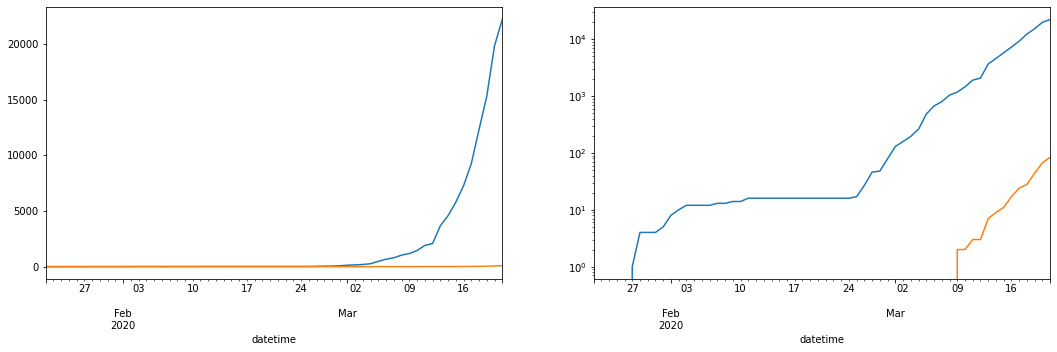

In [0]:
plt.figure(figsize=(18,5))
plt.subplot(121)
dcc.Germany.plot()
ddc.Germany.plot()
plt.subplot(122)
dcc.Germany.plot(logy=True)
ddc.Germany.plot(logy=True)

#### logarithmic scaled plot
* clear exponential growth visible
* the slope seems to flatten at later times

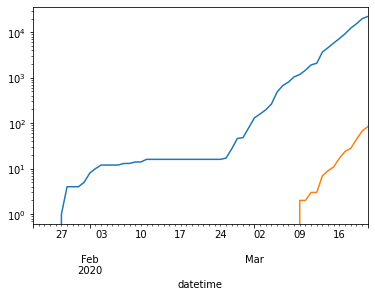

In [0]:
dcc.Germany.plot(logy=True)
ddc.Germany.plot(logy=True)

## Take action to flatten the curve
## Do the restrictions like social distancing have an effect? 
* we study data from other countries like South Korea where a clear effect is visible

### South Korea
* the data from Korea show a drastic flatten of the curve
* pandemic like this often follow a logistic curve


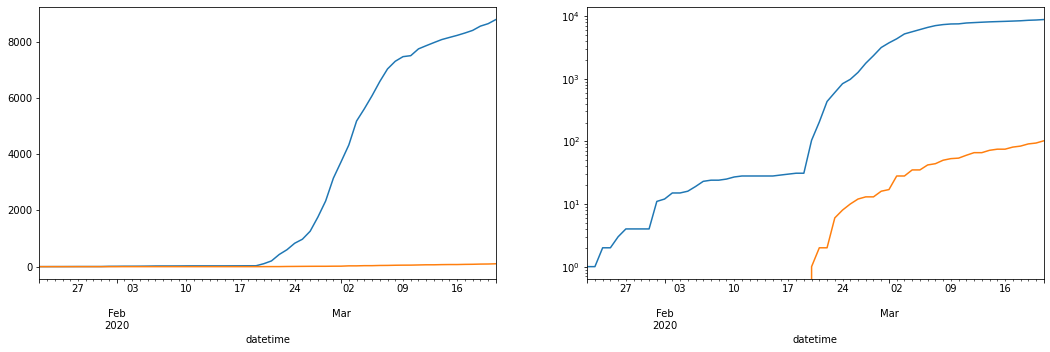

In [0]:
plt.figure(figsize=(18,5))
plt.subplot(121)
dcc['South Korea'].plot()
ddc['South Korea'].plot()
plt.subplot(122)
dcc['South Korea'].plot(logy=True)
ddc['South Korea'].plot(logy=True)

### Different models
* exponential 
* logistic
* ...

In [0]:
#Defining multiple models to describe the growth behavior
def exp_mod(var,day_0,cases_at_day_0,t_double): #Doubling the number of cases every t_double days
    """Returns an exponential function which is 
    scaled by caess_at_day_0
    shifted by day_0
    and has a growth factor of log(2)/t_double,
    where t_double is the time in days in which the function doubles
    """
    return cases_at_day_0*np.exp(np.log(2)*(var-day_0)/t_double)
def lin_mod(var,day_0,cases_at_day_0,t_double): #Linear equivalent of exp_mod in log-space
    """Equivalent to log(exp_mod)"""
    return np.log(cases_at_day_0)+np.log(2)*(var-day_0)/t_double
def logistic_mod_new(var,turning_day,turning_cases,t_double): #
    """Returns the logistic function with
    shifted by turning_day
    a maximum value of 2*turning_cases for var->infty
    and a incliniation at the turning point of slope*turning_cases/2
    """
    slope=np.log(2)/t_double
    return 2*turning_cases/(1+np.exp(-slope*(var-turning_day)))
def lin_log_mod(var,turning_day,turning_cases,t_double):
    """Equivalent to log(lin_mod_new)"""
    slope=np.log(2)/t_double
    return np.log(2*turning_cases/(1+np.exp(-slope*(var-turning_day))))

def dexp_mod(var,day_0,cases_at_day_0,t_double):
    """Returns the derivative of exp_mod"""
    return np.log(2)/t_double*cases_at_day_0*np.exp(np.log(2)*(var-day_0)/t_double)
def dlogistic_mod_new(var,turning_day,turning_cases,t_double):
    """Returns the derivative of logistic_mod"""
    slope=np.log(2)/t_double
    return 2*turning_cases*slope*np.exp(-slope*(var-turning_day))/(1+np.exp(-slope*(var-turning_day)))**2
# helper
def doublingtorate(t_doubling):
    return 2**(1./t_doubling)-1

def format_logi_vals(logi_best_vals_cc):
    string_formatted  = \
    f'Logistic model:\n\
    rate - doubling every: {logi_best_vals_cc[2]:.2f} days\n\
    .... - increase by {(doublingtorate(logi_best_vals_cc[2])*100):.2f}% each day\n\
    Total cases: {2*logi_best_vals_cc[1]:.0f} \n\
    Turning Day: {logi_best_vals_cc[0]:.2f}\n'
    return string_formatted

def format_exp_vals(exp_best_vals_cc):
    string_formatted  = \
    f'Exponential model:\n\
    rate - doubling every: {exp_best_vals_cc[2]:.2f} days\n\
    .... - increase by {doublingtorate(exp_best_vals_cc[2])*100:.2f}% each day\n'
    return string_formatted

### Fit model to data of South Korea

Confirmed cases (green):
Logistic model:
    rate - doubling every: 2.16 days
    .... - increase by 37.92% each day
    Total cases: 8375 
    Turning Day: 39.86

Confirmed cases for last 4 days (red):
Exponential model:
    rate - doubling every: 47.91 days
    .... - increase by 1.46% each day

Dead cases (green):
Logistic model:
    rate - doubling every: 4.15 days
    .... - increase by 18.19% each day
    Total cases: 109 
    Turning Day: 47.67

Dead cases for last 4 days (red):
Exponential model:
    rate - doubling every: 11.27 days
    .... - increase by 6.34% each day



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


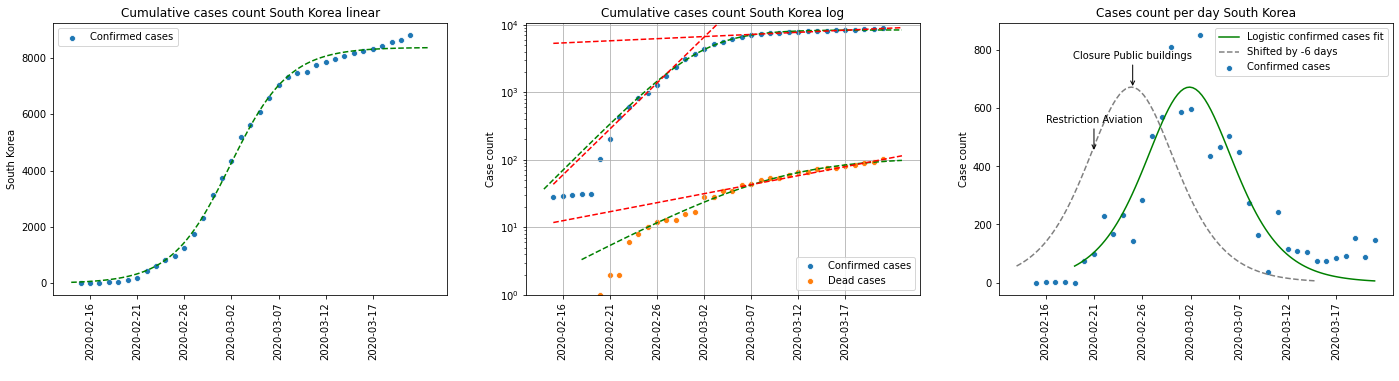

Turning day as date: ['2020-03-02']


In [0]:
#General approach to fitting models to data

#Defining parameters
country = 'South Korea' #Country
start_day_cc = expini.loc[country,'confirmed_day'] #Start day of exponentail growth in confirmed cases
start_date_cc = expini.loc[country,'confirmed_date']
start_cc = dcc.loc[expini.loc[country,'confirmed_date'],country] #Number of confirmed cases at start of exponentail growth
start_day_dc = expini.loc[country,'death_day'] #Start day of exponentail growth in death cases
start_date_dc = expini.loc[country,'death_date']
start_dc = ddc.loc[expini.loc[country,'death_date'],country] #Number of death cases at start of exponentail growth
latest_date = dcc.last_valid_index()
latest_day = dcc.loc[dcc.last_valid_index(),'day'] #Most recent datapoint(day)
latest_cc = dcc.loc[dcc.last_valid_index(),country] #Most recent datapoint(number_confirmed_cases)
latest_dc = ddc.loc[ddc.last_valid_index(),country] #Most recent datapoint(number_death_cases)

#Plotting details
plt.figure(figsize=(24,5))
plt.subplot(131)
sns.scatterplot(x=dcc.loc[start_date_cc:,'day'], y=dcc.loc[start_date_cc:,country], label='Confirmed cases')
plt.title('Cumulative cases count ' + country + ' linear')
# date x ticks
xtick_pos = range(25,60,5)
plt.xticks(xtick_pos, [dcc.loc[dcc['day']==i].index.format('{%M-%d}')[1] for i in xtick_pos], rotation=90)
plt.xlabel('')

plt.subplot(132)

#Setting range of days and parameters for fitting confirmed cases
init_vals = [latest_day,latest_cc,2] #Using the most recent datapoint and a 2-day doubling rate as starting values
low_bound = [start_day_cc,start_cc,0.1] #Using the first datapoint and a 0.2-day doubling time as lower bound
upp_bound = [1E3,8E9,1000]

#Logistic fitting for confirmed cases
x = np.linspace(start_day_cc, latest_day, latest_day-start_day_cc+1)
y = dcc.loc[start_date_cc:latest_date,country]
try:
    logi_best_vals_cc, covar = curve_fit(logistic_mod_new,x,y,p0=init_vals, bounds=(low_bound,upp_bound))
    print('Confirmed cases (green):')
    print(format_logi_vals(logi_best_vals_cc))
    x = np.linspace(start_day_cc-1, latest_day+2, 100)
    plt.plot(x,logistic_mod_new(x,*logi_best_vals_cc), 'g--')
except:
    exp_best_vals_cc, covar = curve_fit(exp_mod,x,y,p0=init_vals, bounds=(low_bound,upp_bound))
    print('Logistic model not possible: Exponential model of confirmed cases (green):')
    print(format_exp_vals(exp_best_vals_cc))

plt.subplot(131)
plt.plot(x,logistic_mod_new(x,*logi_best_vals_cc), 'g--')
plt.subplot(132)

#Exponential model for confirmed cases of last 4 days    
x = np.linspace(latest_day-3, latest_day, 4)
#y = np.log(dcc.loc[latest_day-3:latest_day,country])
y = np.log(dcc.last('4d')[country])
exp_best_vals_cc, covar = curve_fit(lin_mod,x,y,p0=logi_best_vals_cc, bounds=(low_bound,upp_bound))
print('Confirmed cases for last 4 days (red):')
print(format_exp_vals(exp_best_vals_cc))
x = np.linspace(start_day_cc, latest_day+2, 100)
plt.plot(x,exp_mod(x,*exp_best_vals_cc), 'r--')

#South Korea Start
x = np.linspace(start_day_cc, latest_day+2, 100)
plt.plot(x,exp_mod(x,34,1E3,2.21), 'r--')

#Actual Data of confirmed cases
sns.scatterplot(x=dcc.loc[start_date_cc:,'day'], y=dcc.loc[start_date_cc:,country], label='Confirmed cases')

#Setting range of days and parameters for fitting dead cases
init_vals = [latest_day,latest_cc,2] #Using the most recent datapoint and a 2-day doubling rate as starting values
low_bound = [start_day_cc,start_cc,0.1] #Using the first datapoint and a 0.2-day doubling time as lower bound
upp_bound = [1E3,8E9,1000]

#Logistic fitting for dead cases
x = np.linspace(start_day_dc, latest_day, latest_day-start_day_dc+1)
y = ddc.loc[start_date_dc:latest_date,country]
try:
    logi_best_vals, covar = curve_fit(logistic_mod_new,x,y,p0=init_vals, bounds=(low_bound,upp_bound))
    print('Dead cases (green):')
    print(format_logi_vals(logi_best_vals))
    x = np.linspace(start_day_dc-1, latest_day+2, 100)
    plt.plot(x,logistic_mod_new(x,*logi_best_vals), 'g--')
except:
    exp_best_vals, covar = curve_fit(exp_mod,x,y,p0=init_vals, bounds=(low_bound,upp_bound))
    print('Logistic model not possible: Exponential model of dead cases (green):')
    print(format_exp_vals(exp_best_vals))

#Exponential model for dead cases of last 4 days    
x = np.linspace(latest_day-3, latest_day, 4)
y = np.log(ddc.last('4d')[country])
exp_best_vals, covar = curve_fit(lin_mod,x,y,p0=logi_best_vals, bounds=(low_bound,upp_bound))
print('Dead cases for last 4 days (red):')
print(format_exp_vals(exp_best_vals))
x = np.linspace(start_day_cc, latest_day+2, 100)
plt.plot(x,exp_mod(x,*exp_best_vals), 'r--')

#Actual Data of dead cases
sns.scatterplot(x=ddc.loc[start_date_dc:,'day'], y=ddc[country].loc[start_date_dc:], label='Dead cases')

#Plotspecifications           
plt.yscale('log')
plt.ylim(bottom=1, top=1.2*latest_cc) #top=2.2*best_vals[1]
plt.grid()
plt.title('Cumulative cases count ' + country + ' log')
plt.ylabel('Case count')
#plt.xlabel('Days since 22.01.20')

# xlabels
xtick_pos = range(25,60,5)
plt.xticks(xtick_pos, [dcc.loc[dcc['day']==i].index.format('{%M-%d}')[1] for i in xtick_pos], rotation=90)
plt.xlabel(' ')

plt.subplot(133)
x = np.linspace(start_day_dc, latest_day, 100)
plt.plot(x,dlogistic_mod_new(x,*logi_best_vals_cc), 'g-', label='Logistic confirmed cases fit')
plt.plot(x-6,dlogistic_mod_new(x,*logi_best_vals_cc), '--', label='Shifted by -6 days', color='grey')
sns.scatterplot(x=dcc.loc[start_date_cc:,'day'], y=dcc[country].diff().loc[start_date_cc:], label='Confirmed cases')
plt.title('Cases count per day ' + country)
plt.ylabel('Case count')
#plt.xlabel('Days since 22.01.20')
plt.xlabel(' ')

# xlabels
xtick_pos = range(25,60,5)
plt.xticks(xtick_pos, [dcc.loc[dcc['day']==i].index.format('{%M-%d}')[1] for i in xtick_pos], rotation=90)

# annotation
ax = plt.gca()
ax.annotate('Restriction Aviation', xy=(30,450), xytext=(30,450+100),
            arrowprops={'arrowstyle': '->'}, ha='center')
ax.annotate('Closure Public buildings', xy=(34,670), xytext=(34,670+100),
            arrowprops={'arrowstyle': '->'}, ha='center')
plt.show()
print('Turning day as date: {}'.format(dcc.loc[dcc['day']==round(logi_best_vals_cc[0])].index.format()))

### Logistic model fit to data of South Korea
The analysis shows following key results:
#### Figure left: Cumulative cases count South Korea linear
* logistic model describes data pretty well
* later times show linear trend

#### Figure center: Cumulative cases count South Korea log
* the exponential growth of the logistic model has a *doubling rate* of **2.16 days** corresponding to an increase by **37.92%** each day
* *limit value* of total cases is **8375**
* the *turning day* is at **2020-03-02** (day 40) and describes the day when the growth rate decreases 
* the *last 4 days* have a *doubling rate* of **47.91 days** corresponding to an increase by **1.46%** each day
* the *dead cases* show a similar behaviour **shifted by 8 days**

#### Figure right: Cases count per day South Korea
* the *turning day* at **2020-03-02** is visible as peak in the daily increase of cases
* an effect of *counter measures* is visible after **6 days** as can be seen in the shifted curve

### Result of studying data from South Korea
* South Korea shows a clear logistic behaviour
* dead cases show a similar behaviour to the confirmed cases and follow after 8 days
* the effect of counter measures becomes visible after 6 days

## Effect of counter meassures in Germany
* with the results from South Korea we analyze the data from Germany
* Especially, we like to see if the effect of counter measures becomes visible

Confirmed cases (green):
Logistic model:
    rate - doubling every: 2.31 days
    .... - increase by 35.03% each day
    Total cases: 53706 
    Turning Day: 60.03

Confirmed cases for last 4 days (red):
Exponential model:
    rate - doubling every: 3.42 days
    .... - increase by 22.45% each day

Dead cases (green):
Logistic model:
    rate - doubling every: 1.90 days
    .... - increase by 43.89% each day
    Total cases: 506 
    Turning Day: 63.38



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Dead cases for last 4 days (red):
Exponential model:
    rate - doubling every: 1.87 days
    .... - increase by 45.01% each day



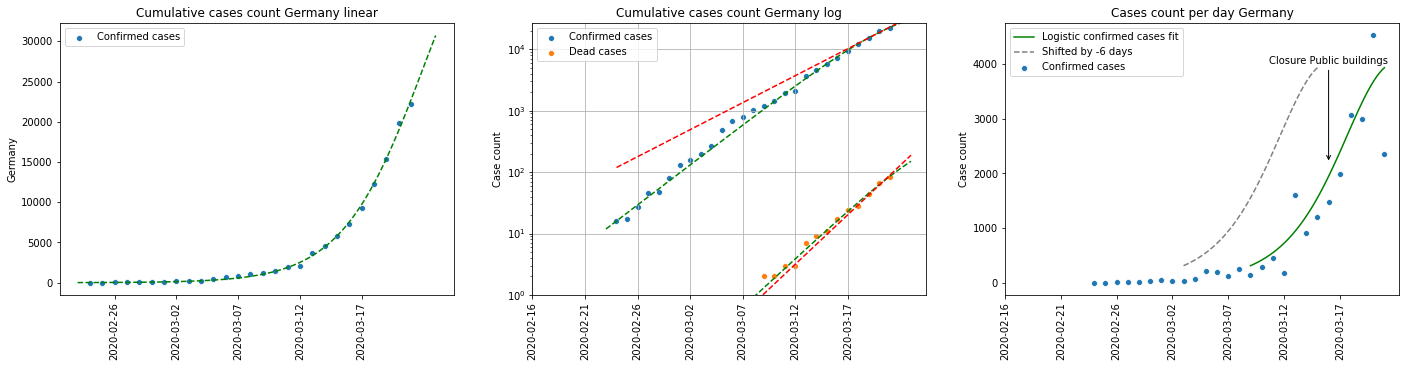

Turning day as date: []


In [0]:
#General approach to fitting models to data

#Defining parameters
country = 'Germany' #Country
start_day_cc = expini.loc[country,'confirmed_day'] #Start day of exponentail growth in confirmed cases
start_date_cc = expini.loc[country,'confirmed_date']
start_cc = dcc.loc[expini.loc[country,'confirmed_date'],country] #Number of confirmed cases at start of exponentail growth
start_day_dc = expini.loc[country,'death_day'] #Start day of exponentail growth in death cases
start_date_dc = expini.loc[country,'death_date']
start_dc = ddc.loc[expini.loc[country,'death_date'],country] #Number of death cases at start of exponentail growth
latest_date = dcc.last_valid_index()
latest_day = dcc.loc[dcc.last_valid_index(),'day'] #Most recent datapoint(day)
latest_cc = dcc.loc[dcc.last_valid_index(),country] #Most recent datapoint(number_confirmed_cases)
latest_dc = ddc.loc[ddc.last_valid_index(),country] #Most recent datapoint(number_death_cases)

#Plotting details
plt.figure(figsize=(24,5))
plt.subplot(131)
sns.scatterplot(x=dcc.loc[start_date_cc:,'day'], y=dcc.loc[start_date_cc:,country], label='Confirmed cases')
plt.title('Cumulative cases count ' + country + ' linear')
# date x ticks
xtick_pos = range(25,60,5)
plt.xticks(xtick_pos, [dcc.loc[dcc['day']==i].index.format('{%M-%d}')[1] for i in xtick_pos], rotation=90)
plt.xlabel('')

plt.subplot(132)

#Setting range of days and parameters for fitting confirmed cases
init_vals = [latest_day,latest_cc,2] #Using the most recent datapoint and a 2-day doubling rate as starting values
low_bound = [start_day_cc,start_cc,0.1] #Using the first datapoint and a 0.2-day doubling time as lower bound
upp_bound = [1E3,8E9,1000]

#Logistic fitting for confirmed cases
x = np.linspace(start_day_cc, latest_day, latest_day-start_day_cc+1)
y = dcc.loc[start_date_cc:latest_date,country]
try:
    logi_best_vals_cc, covar = curve_fit(logistic_mod_new,x,y,p0=init_vals, bounds=(low_bound,upp_bound))
    print('Confirmed cases (green):')
    print(format_logi_vals(logi_best_vals_cc))
    x = np.linspace(start_day_cc-1, latest_day+2, 100)
    plt.plot(x,logistic_mod_new(x,*logi_best_vals_cc), 'g--')
except:
    exp_best_vals_cc, covar = curve_fit(exp_mod,x,y,p0=init_vals, bounds=(low_bound,upp_bound))
    print('Logistic model not possible: Exponential model of confirmed cases (green):')
    print(format_exp_vals(exp_best_vals_cc))

plt.subplot(131)
plt.plot(x,logistic_mod_new(x,*logi_best_vals_cc), 'g--')
plt.subplot(132)

#Exponential model for confirmed cases of last 4 days    
x = np.linspace(latest_day-3, latest_day, 4)
#y = np.log(dcc.loc[latest_day-3:latest_day,country])
y = np.log(dcc.last('4d')[country])
exp_best_vals_cc, covar = curve_fit(lin_mod,x,y,p0=logi_best_vals_cc, bounds=(low_bound,upp_bound))
print('Confirmed cases for last 4 days (red):')
print(format_exp_vals(exp_best_vals_cc))
x = np.linspace(start_day_cc, latest_day+2, 100)
plt.plot(x,exp_mod(x,*exp_best_vals_cc), 'r--')

#Actual Data of confirmed cases
sns.scatterplot(x=dcc.loc[start_date_cc:,'day'], y=dcc.loc[start_date_cc:,country], label='Confirmed cases')

#Setting range of days and parameters for fitting dead cases
init_vals = [latest_day,latest_cc,2] #Using the most recent datapoint and a 2-day doubling rate as starting values
low_bound = [start_day_cc,start_cc,0.1] #Using the first datapoint and a 0.2-day doubling time as lower bound
upp_bound = [1E3,8E9,1000]

#Logistic fitting for dead cases
x = np.linspace(start_day_dc, latest_day, latest_day-start_day_dc+1)
y = ddc.loc[start_date_dc:latest_date,country]
try:
    logi_best_vals, covar = curve_fit(logistic_mod_new,x,y,p0=init_vals, bounds=(low_bound,upp_bound))
    print('Dead cases (green):')
    print(format_logi_vals(logi_best_vals))
    x = np.linspace(start_day_dc-1, latest_day+2, 100)
    plt.plot(x,logistic_mod_new(x,*logi_best_vals), 'g--')
except:
    exp_best_vals, covar = curve_fit(exp_mod,x,y,p0=init_vals, bounds=(low_bound,upp_bound))
    print('Logistic model not possible: Exponential model of dead cases (green):')
    print(format_exp_vals(exp_best_vals))

#Exponential model for dead cases of last 4 days    
x = np.linspace(latest_day-3, latest_day, 4)
y = np.log(ddc.last('4d')[country])
exp_best_vals, covar = curve_fit(lin_mod,x,y,p0=logi_best_vals, bounds=(low_bound,upp_bound))
print('Dead cases for last 4 days (red):')
print(format_exp_vals(exp_best_vals))
x = np.linspace(start_day_cc, latest_day+2, 100)
plt.plot(x,exp_mod(x,*exp_best_vals), 'r--')

#Actual Data of dead cases
sns.scatterplot(x=ddc.loc[start_date_dc:,'day'], y=ddc[country].loc[start_date_dc:], label='Dead cases')

#Plotspecifications           
plt.yscale('log')
plt.ylim(bottom=1, top=1.2*latest_cc) #top=2.2*best_vals[1]
plt.grid()
plt.title('Cumulative cases count ' + country + ' log')
plt.ylabel('Case count')
#plt.xlabel('Days since 22.01.20')

# xlabels
xtick_pos = range(25,60,5)
plt.xticks(xtick_pos, [dcc.loc[dcc['day']==i].index.format('{%M-%d}')[1] for i in xtick_pos], rotation=90)
plt.xlabel(' ')

plt.subplot(133)
x = np.linspace(start_day_dc, latest_day, 100)
plt.plot(x,dlogistic_mod_new(x,*logi_best_vals_cc), 'g-', label='Logistic confirmed cases fit')
plt.plot(x-6,dlogistic_mod_new(x,*logi_best_vals_cc), '--', label='Shifted by -6 days', color='grey')
sns.scatterplot(x=dcc.loc[start_date_cc:,'day'], y=dcc[country].diff().loc[start_date_cc:], label='Confirmed cases')
plt.title('Cases count per day ' + country)
plt.ylabel('Case count')
#plt.xlabel('Days since 22.01.20')
plt.xlabel(' ')

# xlabels
xtick_pos = range(25,60,5)
plt.xticks(xtick_pos, [dcc.loc[dcc['day']==i].index.format('{%M-%d}')[1] for i in xtick_pos], rotation=90)

# annotation
ax = plt.gca()
#ax.annotate('Restriction Aviation', xy=(30,450), xytext=(30,450+100),
#            arrowprops={'arrowstyle': '->'}, ha='center')
ax.annotate('Closure Public buildings', xy=(54,2200), xytext=(54,2200+1800),
            arrowprops={'arrowstyle': '->'}, ha='center')
plt.show()
print('Turning day as date: {}'.format(dcc.loc[dcc['day']==round(logi_best_vals_cc[0])].index.format()))

### Logistic model fit to data of Germany
The analysis shows following key results:
#### Figure left: Cumulative cases count Germany linear
* logistic model describes data pretty well
* later times show linear trend

#### Figure center: Cumulative cases count Germany log
* the exponential growth of the logistic model has a *doubling rate* of **2.31 days** corresponding to an increase by **35.03%** each day
* *limit value* of total cases is **53706**
* the *turning day* is at **2020-03-22** (day 60) and describes the day when the growth rate decreases 
* the *last 4 days* have a *doubling rate* of **3.42 days** corresponding to an increase by **22.45%** each day

#### Figure right: Cases count per day Germany
* an effect of *counter measures* might be visible since the last data point is significantly lower

*Caution: The most recent data could still change.*